In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS

# Periodic Boundary Condition Time Evolution

We are going to check the validity of the MPO for time evolution with the pbc hamiltonian. Hence, we are going to perform exact diagonalization with sparse matrices and compare the results.

## 1. Exact Time Evolution

We are going to perform two types of evolution:
- a. Start with the vacuum in the roughening, apply a string operator, evolve with the same hamiltonian
- b. Start with the string in the confined, evolve with the hamiltonian in the roughening region

### 1.a.1 Dual Hamiltonian in the vacuum roughening region

In [2]:
def electric_dual_ham(l: int, L: int, cx: list=[], cy: list=[]):
    dof = l*L + 1
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()

    # first column of sigma are local
    for j in range(l):
        H_sigmas += sparse_pauli_z(n=j*L, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

    # vertical zz interactions 
    for i in range(L):
        for j in range(l):
            H_taus += np.prod(charges[(j+1)%l,:(i+1)]) * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)

    return H_sigmas + H_taus

def magnetic_dual_ham(l: int, L: int):
    dof = l*L + 1
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_plaquettes = O

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)
    return H_plaquettes

def dual_ham(l,L,g, cx: list=[], cy: list=[]):
    # electric vertical and horizontal terms
    H_el = electric_dual_ham(l,L,cx,cy)

    # magnetic plaquette terms
    H_mag = magnetic_dual_ham(l,L)

    return - g * H_el - 1/g * H_mag

In [3]:
l = 2
L = 3
g = 0.75
H_vr = dual_ham(l,L,g)
e, psi0 = diagonalization(H_vr, sparse=True)
print(len(e),psi0.shape, e)

1 (128, 1) [-12.3119519]


In [4]:
# charges
cx = [1,2]
cy = [0,0]
charges = np.ones((l,L+1))
if len(cx) != 0:
    charges[cy[0],cx[0]] = -1
    charges[cy[1],cx[1]] = -1
prod_charges = np.prod(charges, axis=1).tolist()
print(charges)
print(prod_charges)
i = 1
j = 3
print(charges[(i+1)%l,:(j+1)])

[[ 1. -1. -1.  1.]
 [ 1.  1.  1.  1.]]
[1.0, 1.0]
[ 1. -1. -1.  1.]


### 1.a.2 Application of the string operator

In [5]:
def string_operator(cx: list=None, cy: list=None):
    
    
    pass

### 1.a.3 Evolution with the Dual Hamiltonian in the vacuum roughening region

### 1.b.1 Dual Hamiltonian in the string confined region

In [7]:
l = 1
L = 1
g = 10
cx = [0,1]
cy = [0,0]
H_sc = dual_ham(l,L,g,cx,cy)
e, psi0 = diagonalization(H_sc, sparse=True)
print(len(e),psi0.shape, e)
psi0 = psi0.reshape(2**(l*L+1))

1 (4, 1) [-10.00025]


### 1.b.2 Evolution with Dual Hamiltonian in the string roughening region

In [296]:
l = 2
L = 3
g_r = 0.70
cx = [1,2]
cy = [0,0]
steps = 100
delta = 0.01
from scipy.sparse.linalg import expm, expm_multiply

H_sr = dual_ham(l,L,g_r,cx,cy)

# observable, e.g. fidelity
fid = []
for N in range(steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    # U_sr = expm(-1j*t*H_sr)
    # psi_ev = U_sr @ psi0
    psi_ev = expm_multiply(-1j*t*H_sr, psi0)
    overlap = (psi_ev.T.conjugate() @ psi0)
    fid.append(overlap)
    print(f"fidelity: {overlap}")

exact evolution at time: 0.0
fidelity: (1+0j)
exact evolution at time: 0.01
fidelity: (0.9958455035677568-0.08414365267981627j)
exact evolution at time: 0.02
fidelity: (0.9834268382003934-0.16744106269620268j)
exact evolution at time: 0.03
fidelity: (0.9628779521648836-0.24905558428498978j)
exact evolution at time: 0.04
fidelity: (0.9344203538432826-0.3281696509132299j)
exact evolution at time: 0.05
fidelity: (0.8983605257531372-0.40399402987957594j)
exact evolution at time: 0.06
fidelity: (0.8550863481248813-0.47577673880735516j)
exact evolution at time: 0.07
fidelity: (0.8050625753337324-0.5428115177941908j)
exact evolution at time: 0.08
fidelity: (0.7488254199329034-0.604445756421193j)
exact evolution at time: 0.09
fidelity: (0.686976309809117-0.6600877814960322j)
exact evolution at time: 0.1
fidelity: (0.6201748939476143-0.7092134192248626j)
exact evolution at time: 0.11
fidelity: (0.5491313813295527-0.7513717543810519j)
exact evolution at time: 0.12
fidelity: (0.47459830547874104-

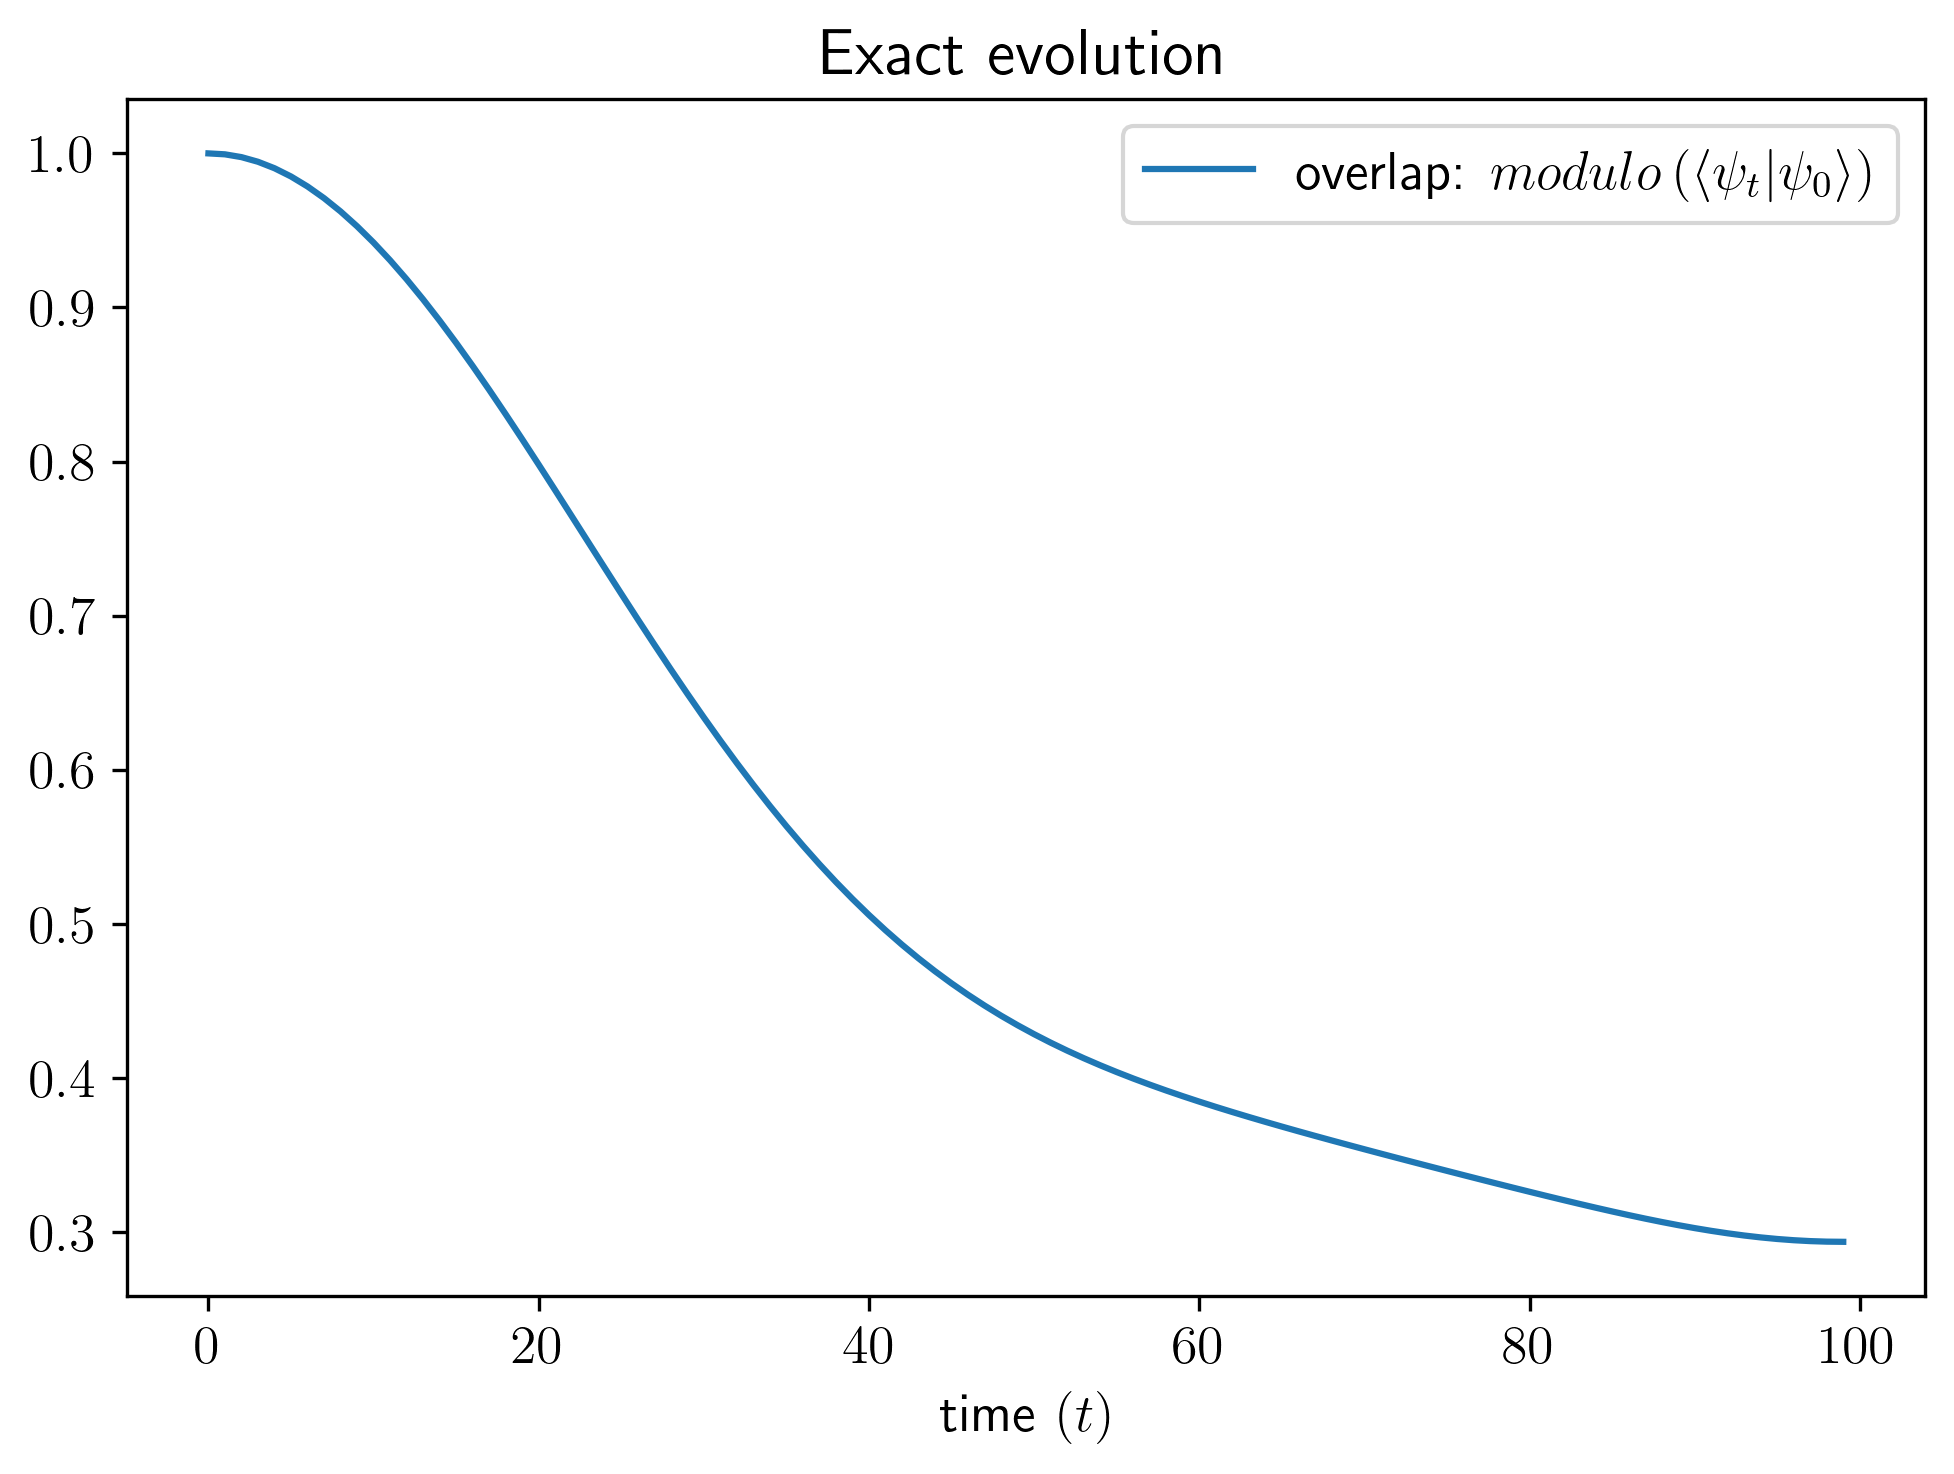

In [297]:
# plt.plot(range(steps),[ov.real for ov in fid], label="overlap: $\\Re e \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
# plt.plot(range(steps),[ov.imag for ov in fid], label="overlap: $\\Im m \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.plot(range(steps),[np.sqrt(ov.real**2 + ov.imag**2) for ov in fid], label="overlap: $modulo \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.title("Exact evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

In [298]:
l = 2
L = 3
g_r = 0.7
cx = [1,2]
cy = [0,0]
steps = 100
delta = 0.01
from scipy.sparse.linalg import expm

H_sre = electric_dual_ham(l,L,cx,cy)
H_srm = magnetic_dual_ham(l,L)

# initialize psi and evolution trotter op
psi_ev = psi0.copy()
U_sre = expm(-1j*delta*(-g_r)*H_sre)
U_srm = expm(-1j*delta*(-1/g_r)*H_srm)

# observable, e.g. fidelity
fid_trott1 = []
for N in range(steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    
    # # apply magnetic evolution operator
    psi_ev = U_srm @ psi_ev
    # # apply electric evolution operator
    psi_ev = U_sre @ psi_ev

    overlap = (psi_ev.T.conjugate() @ psi0)
    fid_trott1.append(overlap)
    print(f"fidelity: {overlap}")

## second order trotter
psi_ev = psi0.copy()
U_srm = expm(-1j*(delta/2)*(-1/g_r)*H_srm)

fid_trott2 = []
for N in range(steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    
    psi_ev = U_srm @ psi_ev
    psi_ev = U_sre @ psi_ev
    psi_ev = U_srm @ psi_ev
    
    overlap = (psi_ev.T.conjugate() @ psi0)
    fid_trott2.append(overlap)
    print(f"fidelity: {overlap}")

exact evolution at time: 0.0
fidelity: (0.9958461873562254-0.0841341119934354j)
exact evolution at time: 0.01
fidelity: (0.9834295616851355-0.16742216682301725j)
exact evolution at time: 0.02
fidelity: (0.9628840364242807-0.24902770131328245j)
exact evolution at time: 0.03
fidelity: (0.9344310624972836-0.3281333257415864j)
exact evolution at time: 0.04
fidelity: (0.8983770432110408-0.40394997565695057j)
exact evolution at time: 0.05
fidelity: (0.8551097590425351-0.475725825719084j)
exact evolution at time: 0.06
fidelity: (0.8050938455949788-0.5427547593610025j)
exact evolution at time: 0.07
fidelity: (0.7488653794477061-0.6043842935154562j)
exact evolution at time: 0.08
fidelity: (0.6870256373940364-0.6600228643136714j)
exact evolution at time: 0.09
fidelity: (0.6202341045236555-0.7091463874821118j)
exact evolution at time: 0.1
fidelity: (0.5492008156382444-0.7513040160320494j)
exact evolution at time: 0.11
fidelity: (0.4746781224801541-0.7861230276477283j)
exact evolution at time: 0.1

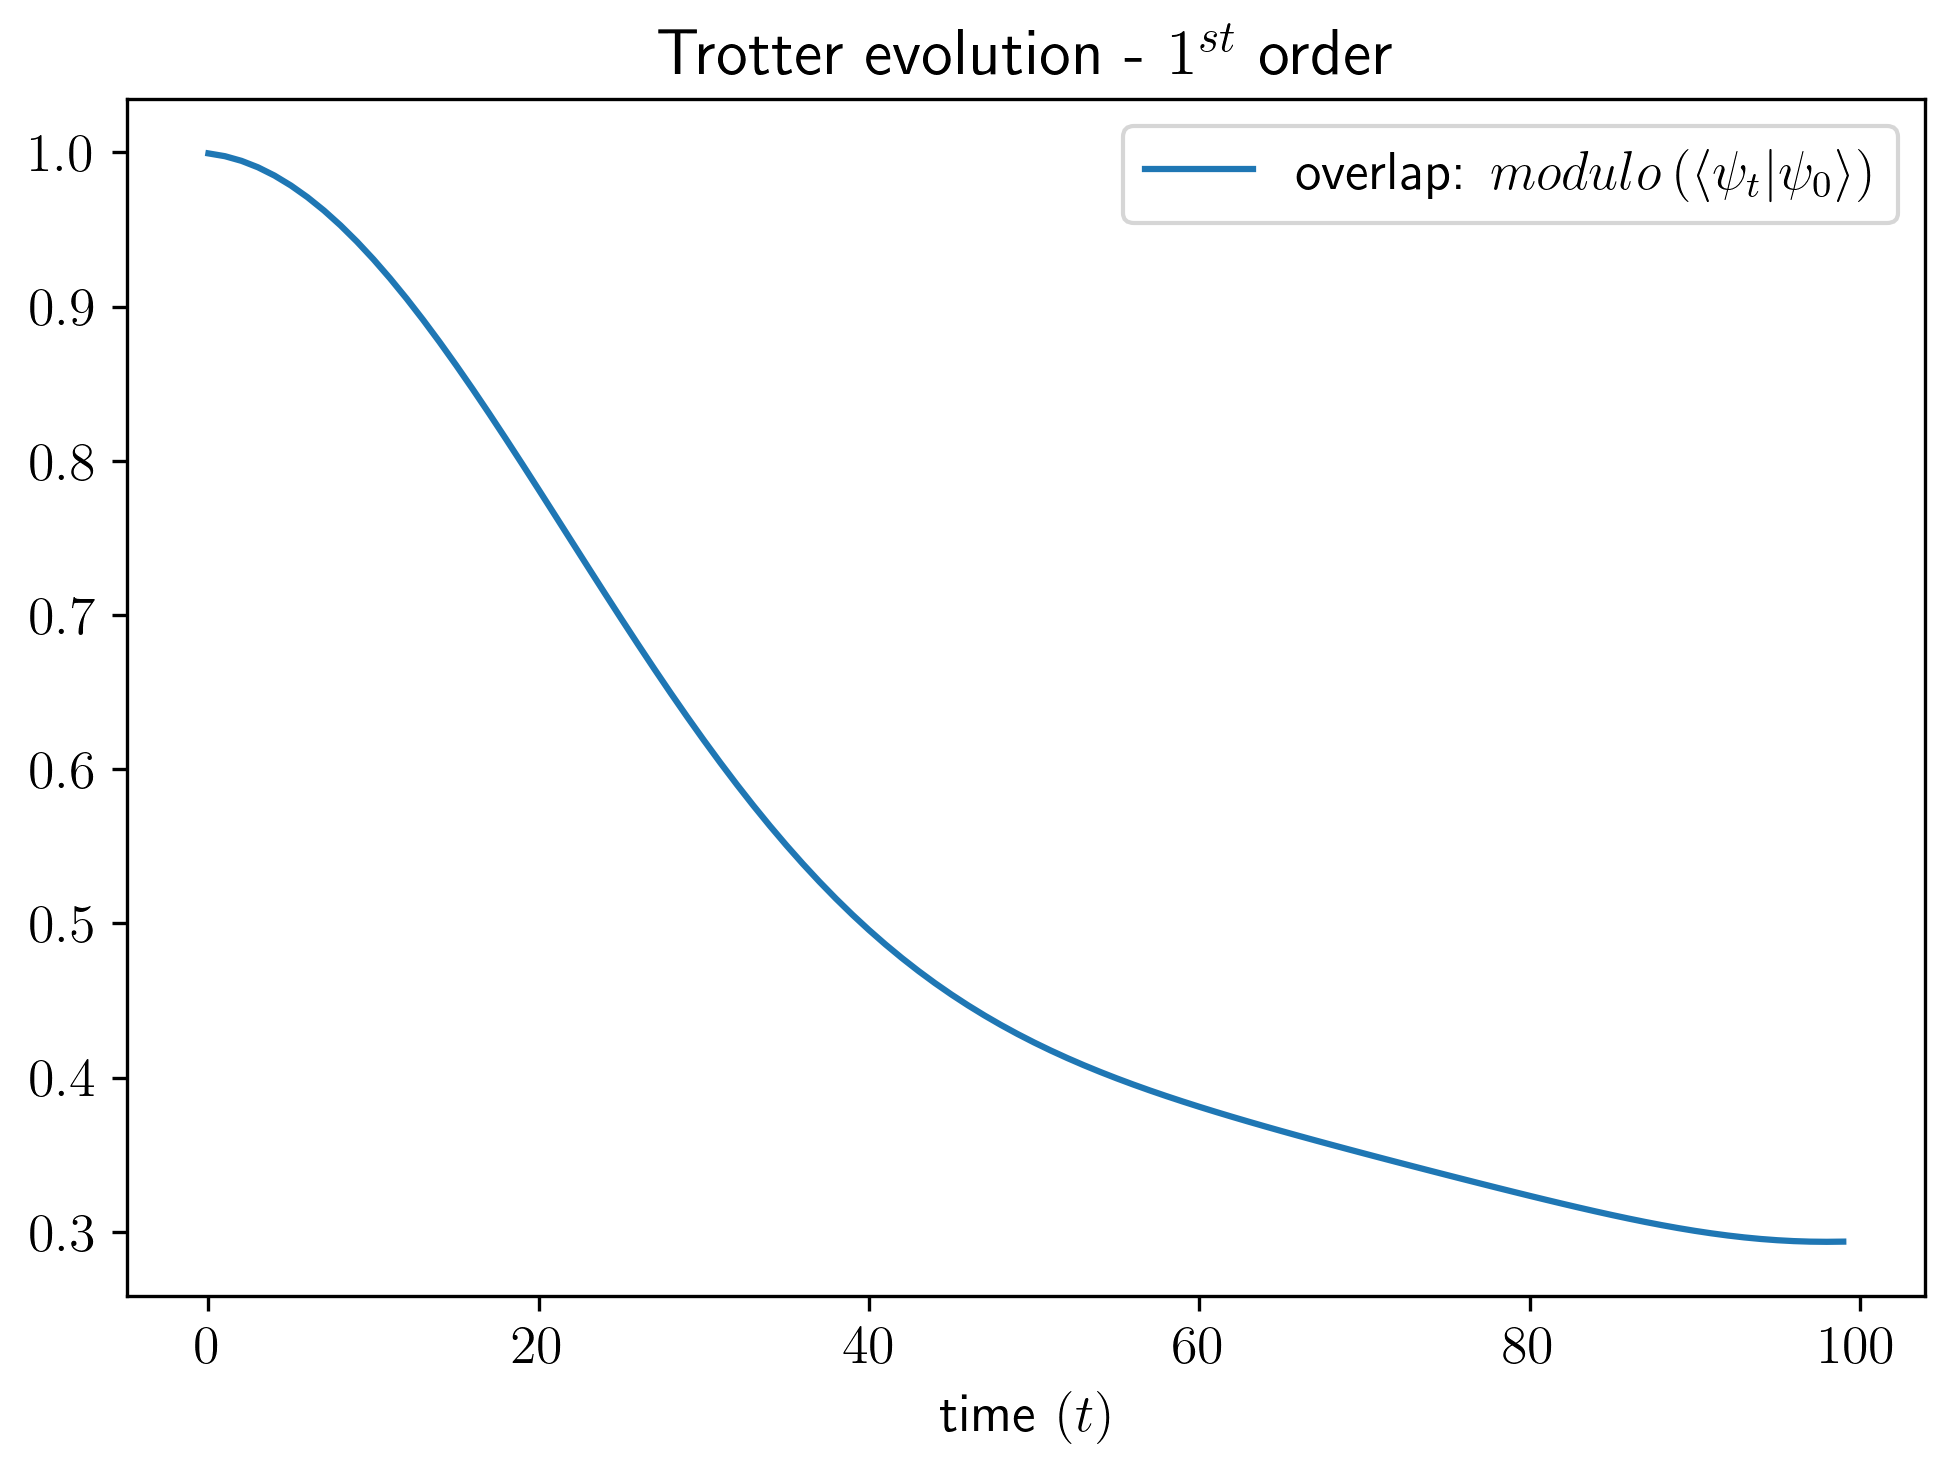

In [299]:
# plt.plot(range(steps),[ov.real for ov in fid_trott1], label="overlap: $\\Re e \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
# plt.plot(range(steps),[ov.imag for ov in fid_trott1], label="overlap: $\\Im m \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.plot(range(steps),[np.sqrt(ov.real**2 + ov.imag**2) for ov in fid_trott1], label="overlap: $modulo \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.title("Trotter evolution - $1^{st}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

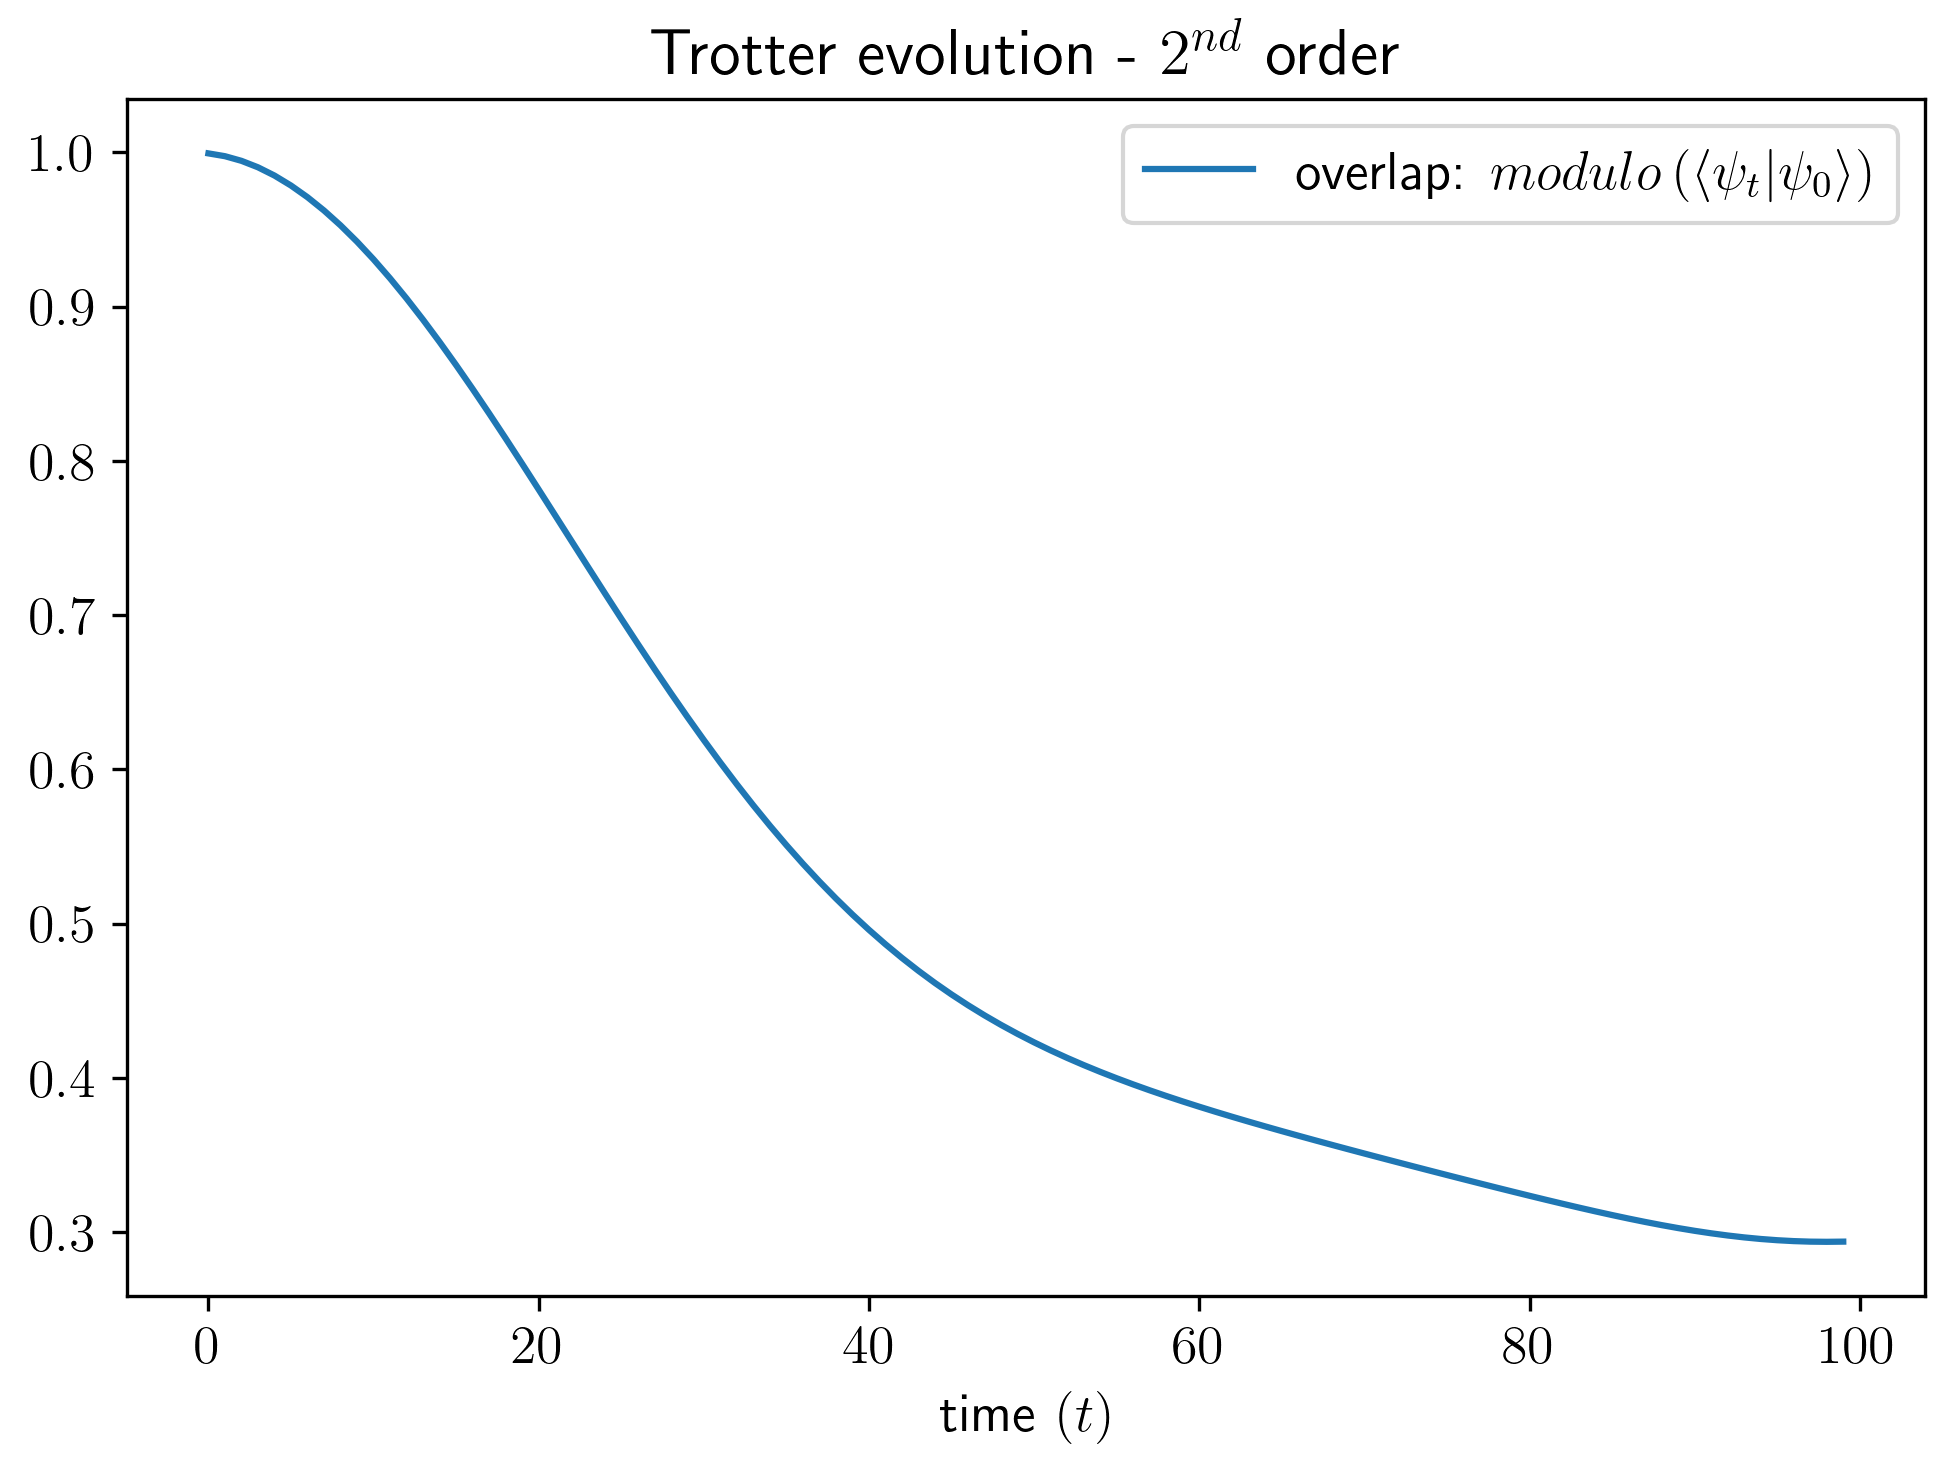

In [300]:
# plt.plot(range(steps),[ov.real for ov in fid_trott2], label="overlap: $\\Re e \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
# plt.plot(range(steps),[ov.imag for ov in fid_trott2], label="overlap: $\\Im m \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.plot(range(steps),[np.sqrt(ov.real**2 + ov.imag**2) for ov in fid_trott2], label="overlap: $modulo \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

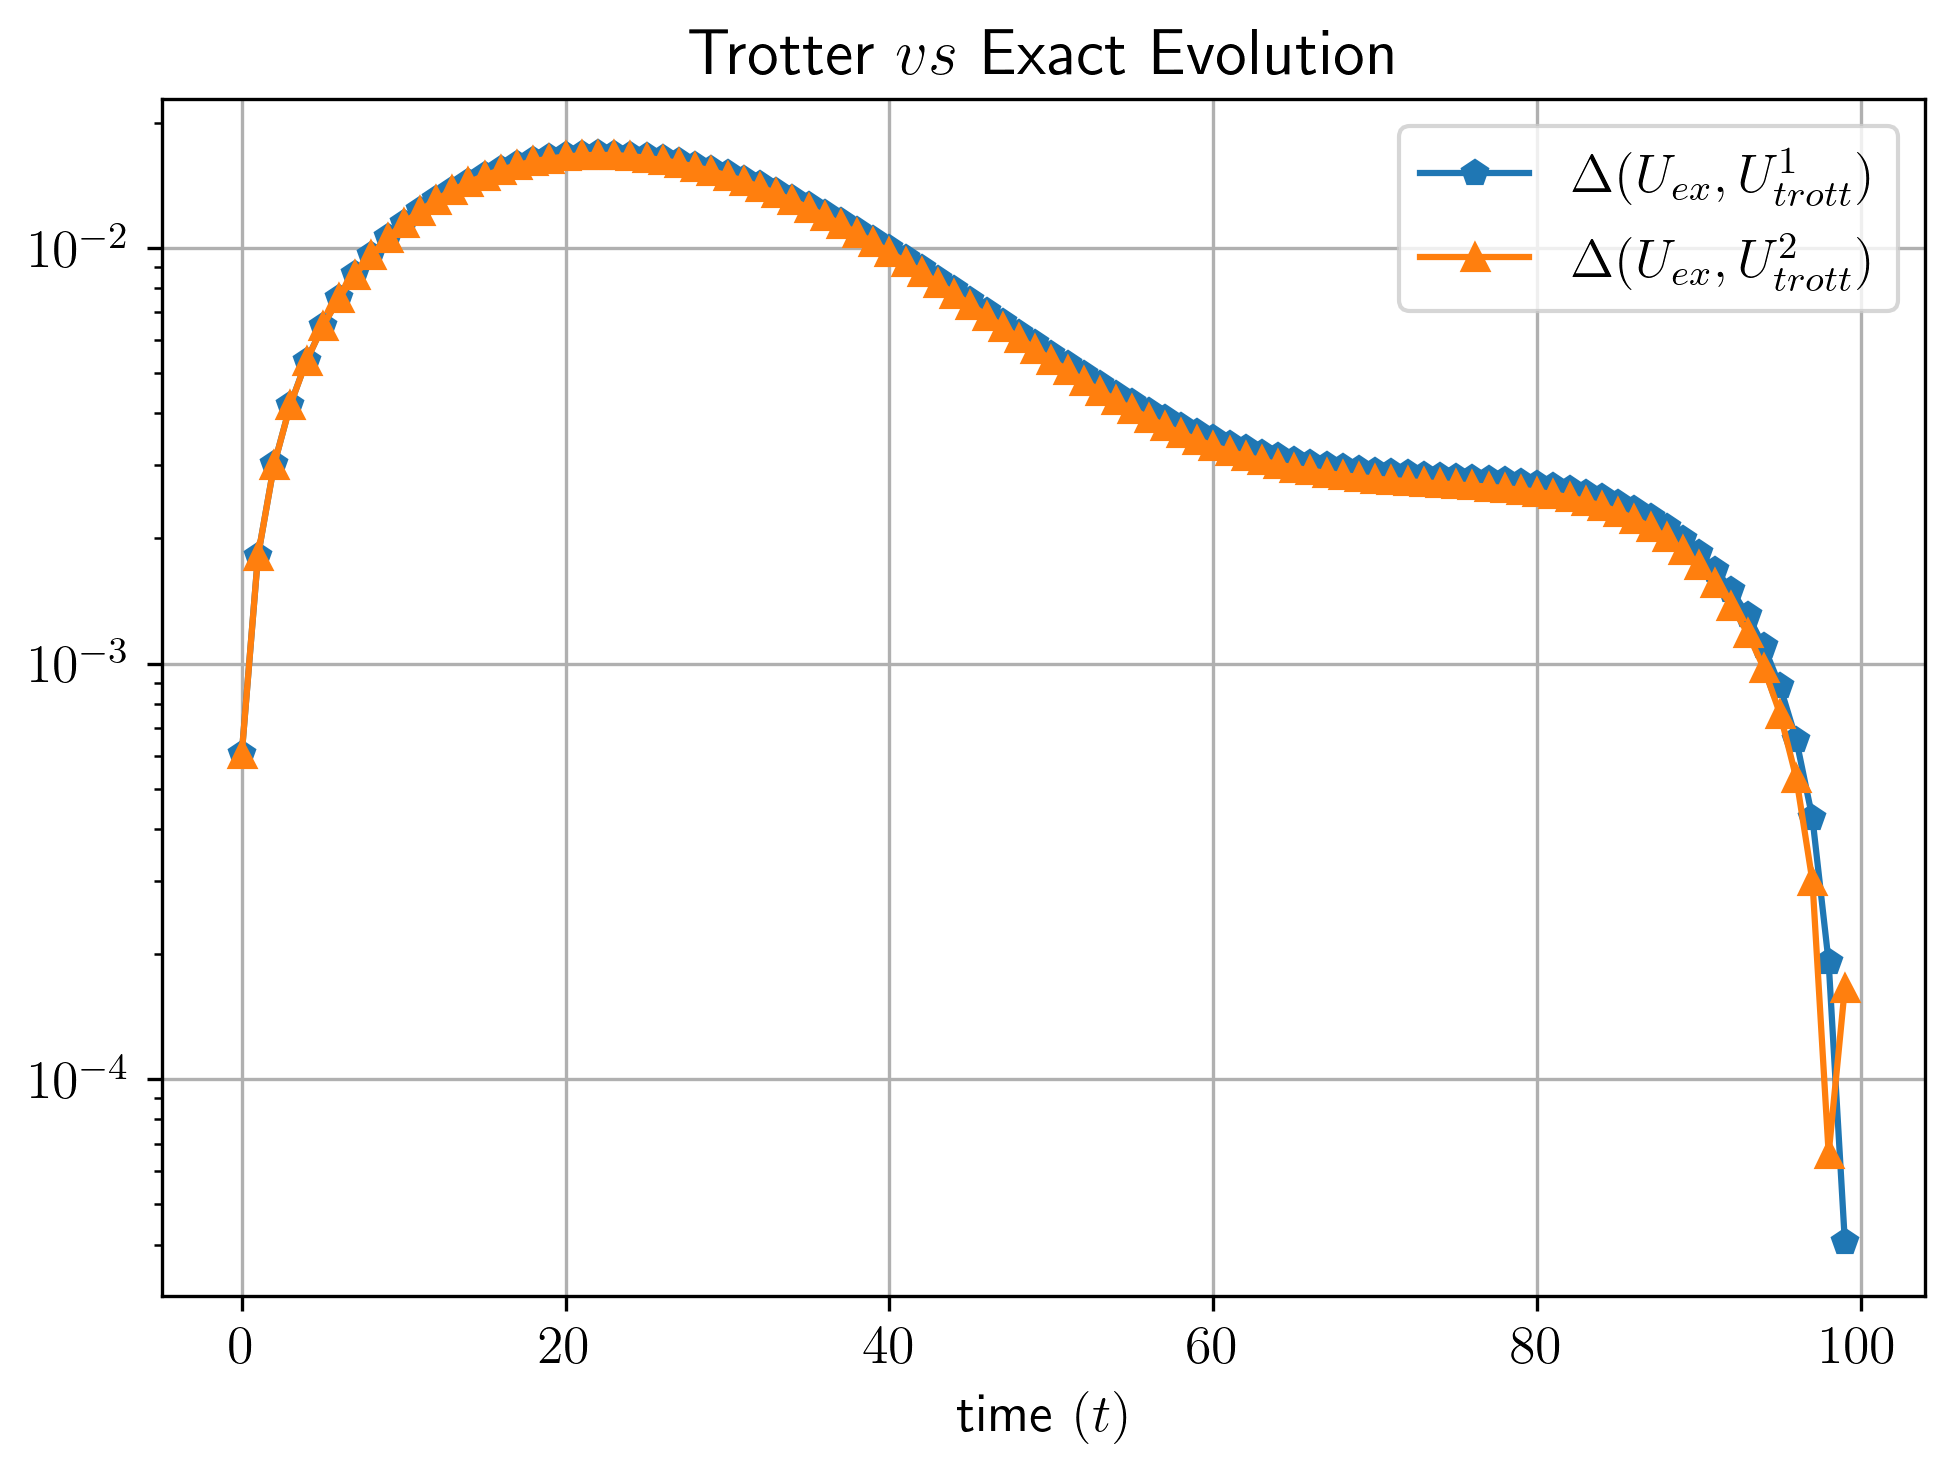

In [301]:
modulo_ex = np.array([np.sqrt(ov.real**2 + ov.imag**2) for ov in fid])
modulo_trott1 = np.array([np.sqrt(ov.real**2 + ov.imag**2) for ov in fid_trott1])
modulo_trott2 = np.array([np.sqrt(ov.real**2 + ov.imag**2) for ov in fid_trott2])
plt.plot(range(steps),abs(modulo_ex - modulo_trott1), marker="p", label="$\\Delta(U_{ex},U_{trott}^1)$")
plt.plot(range(steps),abs(modulo_ex - modulo_trott2), marker="^", label="$\\Delta (U_{ex},U_{trott}^2)$")
plt.title("Trotter $vs$ Exact Evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
def evolution_operator(delta, hamiltonian):
    return expm(-1j*delta*hamiltonian)

def trott_Z2_dual_1(delta, coupling, H_loc, H_int):
    U_loc = evolution_operator(delta=delta*1/coupling, hamiltonian=H_loc)    
    U_int = evolution_operator(delta=delta*coupling, hamiltonian=H_int)
    return U_loc @ U_int
    
def trott_Z2_dual_2(delta, coupling, H_loc, H_int):
    U_loc = evolution_operator(delta=(delta/2)*1/coupling, hamiltonian=H_loc)    
    U_int = evolution_operator(delta=delta*coupling, hamiltonian=H_int)
    return U_loc @ U_int @ U_loc

def trott_Z2_dual(l, L, cx, cy, delta, coupling, ord: int=1):
    H_ev_el = electric_dual_ham(l, L, cx, cy) # zz dual interaction term
    H_ev_mag = magnetic_dual_ham(l, L) # x dual local term
    if ord == 1:
        U_ev = trott_Z2_dual_1(delta, coupling, H_ev_mag, H_ev_el)
    if ord == 2:
        U_ev = trott_Z2_dual_1(delta, coupling, H_ev_mag, H_ev_el)

U_trott = trott_Z2_dual(delta, ord=1)
U_trott2 = trott_Z2_dual(delta, ord=2)
# U_trott4 = trott_Z2_dual(delta, ord=4)

psi_ev_trott = psi0.copy()
psi_ev_trott2 = psi0.copy()
# psi_ev_trott4 = psi0.copy()

diff1 = []
diff2 = []
# diff4 = []
for N in range(1,steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    U_exact = expm(-1j*t*H_ising)
    
    psi_ev_ex = U_exact @ psi0    
    psi_ev_trott = U_trott @ psi_ev_trott
    psi_ev_trott2 = U_trott2 @ psi_ev_trott2
    # psi_ev_trott4 = U_trott4 @ psi_ev_trott4
    
    diff1.append(norm(psi_ev_ex - psi_ev_trott))
    diff2.append(norm(psi_ev_ex - psi_ev_trott2))
    # diff4.append(norm(psi_ev_ex - psi_ev_trott4))

In [64]:
from qs_mps.sparse_hamiltonians_and_operators import sparse_ising_hamiltonian, diagonalization

H_ising = sparse_ising_hamiltonian(J=1,h_t=1, h_l=0, L=2, long="Z")
e, v = diagonalization(H_ising, sparse=True)
print(e, v.shape)
psi0 = v[:,0]
print(psi0)

[-2.23606798] (4, 1)
[0.50625554-0.32482106j 0.31288313-0.20075046j 0.31288313-0.20075046j
 0.50625554-0.32482106j]


In [52]:
delta = 1e-2
U_exact = expm(-1j*delta*H_ising)
U_trott = expm(1j*delta*sparse_pauli_x(n=0,L=2)) @ expm(1j*delta*sparse_pauli_x(n=1,L=2)) @ expm(1j*delta*(sparse_pauli_z(n=0,L=2) @ sparse_pauli_z(n=1,L=2)))
U_trott2 = expm(1j*delta/2*sparse_pauli_x(n=0,L=2)) @ expm(1j*delta/2*sparse_pauli_x(n=1,L=2)) @ expm(1j*delta*(sparse_pauli_z(n=0,L=2) @ sparse_pauli_z(n=1,L=2))) @ expm(1j*delta/2*sparse_pauli_x(n=0,L=2)) @ expm(1j*delta/2*sparse_pauli_x(n=1,L=2))

In [63]:
norm(((U_exact - U_trott) @ psi0))

0.00019998888915807124

In [47]:
from scipy.linalg import norm

psi_ex = U_exact @ psi0
psi_trott = U_trott @ psi0
psi_trott2 = U_trott2 @ psi0
print(norm(psi_ex - psi_trott))
print(norm(psi_ex - psi_trott2))

0.00019998888915800749
9.427760437800068e-07


In [96]:
delta = 1e-1
steps = 99

def trott1(delta: float):
    return expm(1j*delta*sparse_pauli_x(n=0,L=2)) @ expm(1j*delta*sparse_pauli_x(n=1,L=2)) @ expm(1j*delta*(sparse_pauli_z(n=0,L=2) @ sparse_pauli_z(n=1,L=2)))

def trott2(delta: float):
    return expm(1j*delta/2*sparse_pauli_x(n=0,L=2)) @ expm(1j*delta/2*sparse_pauli_x(n=1,L=2)) @ expm(1j*delta*(sparse_pauli_z(n=0,L=2) @ sparse_pauli_z(n=1,L=2))) @ expm(1j*delta/2*sparse_pauli_x(n=0,L=2)) @ expm(1j*delta/2*sparse_pauli_x(n=1,L=2))

def trott(delta: float, ord: int=1):
    if ord == 1:
        return trott1(delta)    
    elif ord == 2:
        return trott2(delta)
    elif ord == 4:
        delta1 = (1/(4-(4**(1/3))))*delta
        delta2 = (1-(4*delta1))*delta
        return trott2(delta1) @ trott2(delta1) @ trott2(delta2) @ trott2(delta1) @ trott2(delta1)

U_trott = trott(delta, ord=1)
U_trott2 = trott(delta, ord=2)
# U_trott4 = trott(delta, ord=4)

psi_ev_trott = psi0.copy()
psi_ev_trott2 = psi0.copy()
# psi_ev_trott4 = psi0.copy()

diff1 = []
diff2 = []
# diff4 = []
for N in range(1,steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    U_exact = expm(-1j*t*H_ising)
    
    psi_ev_ex = U_exact @ psi0    
    psi_ev_trott = U_trott @ psi_ev_trott
    psi_ev_trott2 = U_trott2 @ psi_ev_trott2
    # psi_ev_trott4 = U_trott4 @ psi_ev_trott4
    
    diff1.append(norm(psi_ev_ex - psi_ev_trott))
    diff2.append(norm(psi_ev_ex - psi_ev_trott2))
    # diff4.append(norm(psi_ev_ex - psi_ev_trott4))
    
    # if N%14 == 0:
    #     psi_ev_ex = U_exact @ psi0
    #     psi_ev_trott = U_trott @ psi_ev_trott
    #     diff1.append(norm(psi_ev_ex - psi_ev_trott))
    #     psi_ev_trott2 = U_trott2 @ psi_ev_trott2
    #     diff2.append(norm(psi_ev_ex - psi_ev_trott2))

exact evolution at time: 0.1
exact evolution at time: 0.2
exact evolution at time: 0.30000000000000004
exact evolution at time: 0.4
exact evolution at time: 0.5
exact evolution at time: 0.6000000000000001
exact evolution at time: 0.7000000000000001
exact evolution at time: 0.8
exact evolution at time: 0.9
exact evolution at time: 1.0
exact evolution at time: 1.1
exact evolution at time: 1.2000000000000002
exact evolution at time: 1.3
exact evolution at time: 1.4000000000000001
exact evolution at time: 1.5
exact evolution at time: 1.6
exact evolution at time: 1.7000000000000002
exact evolution at time: 1.8
exact evolution at time: 1.9000000000000001
exact evolution at time: 2.0
exact evolution at time: 2.1
exact evolution at time: 2.2
exact evolution at time: 2.3000000000000003
exact evolution at time: 2.4000000000000004
exact evolution at time: 2.5
exact evolution at time: 2.6
exact evolution at time: 2.7
exact evolution at time: 2.8000000000000003
exact evolution at time: 2.9000000000

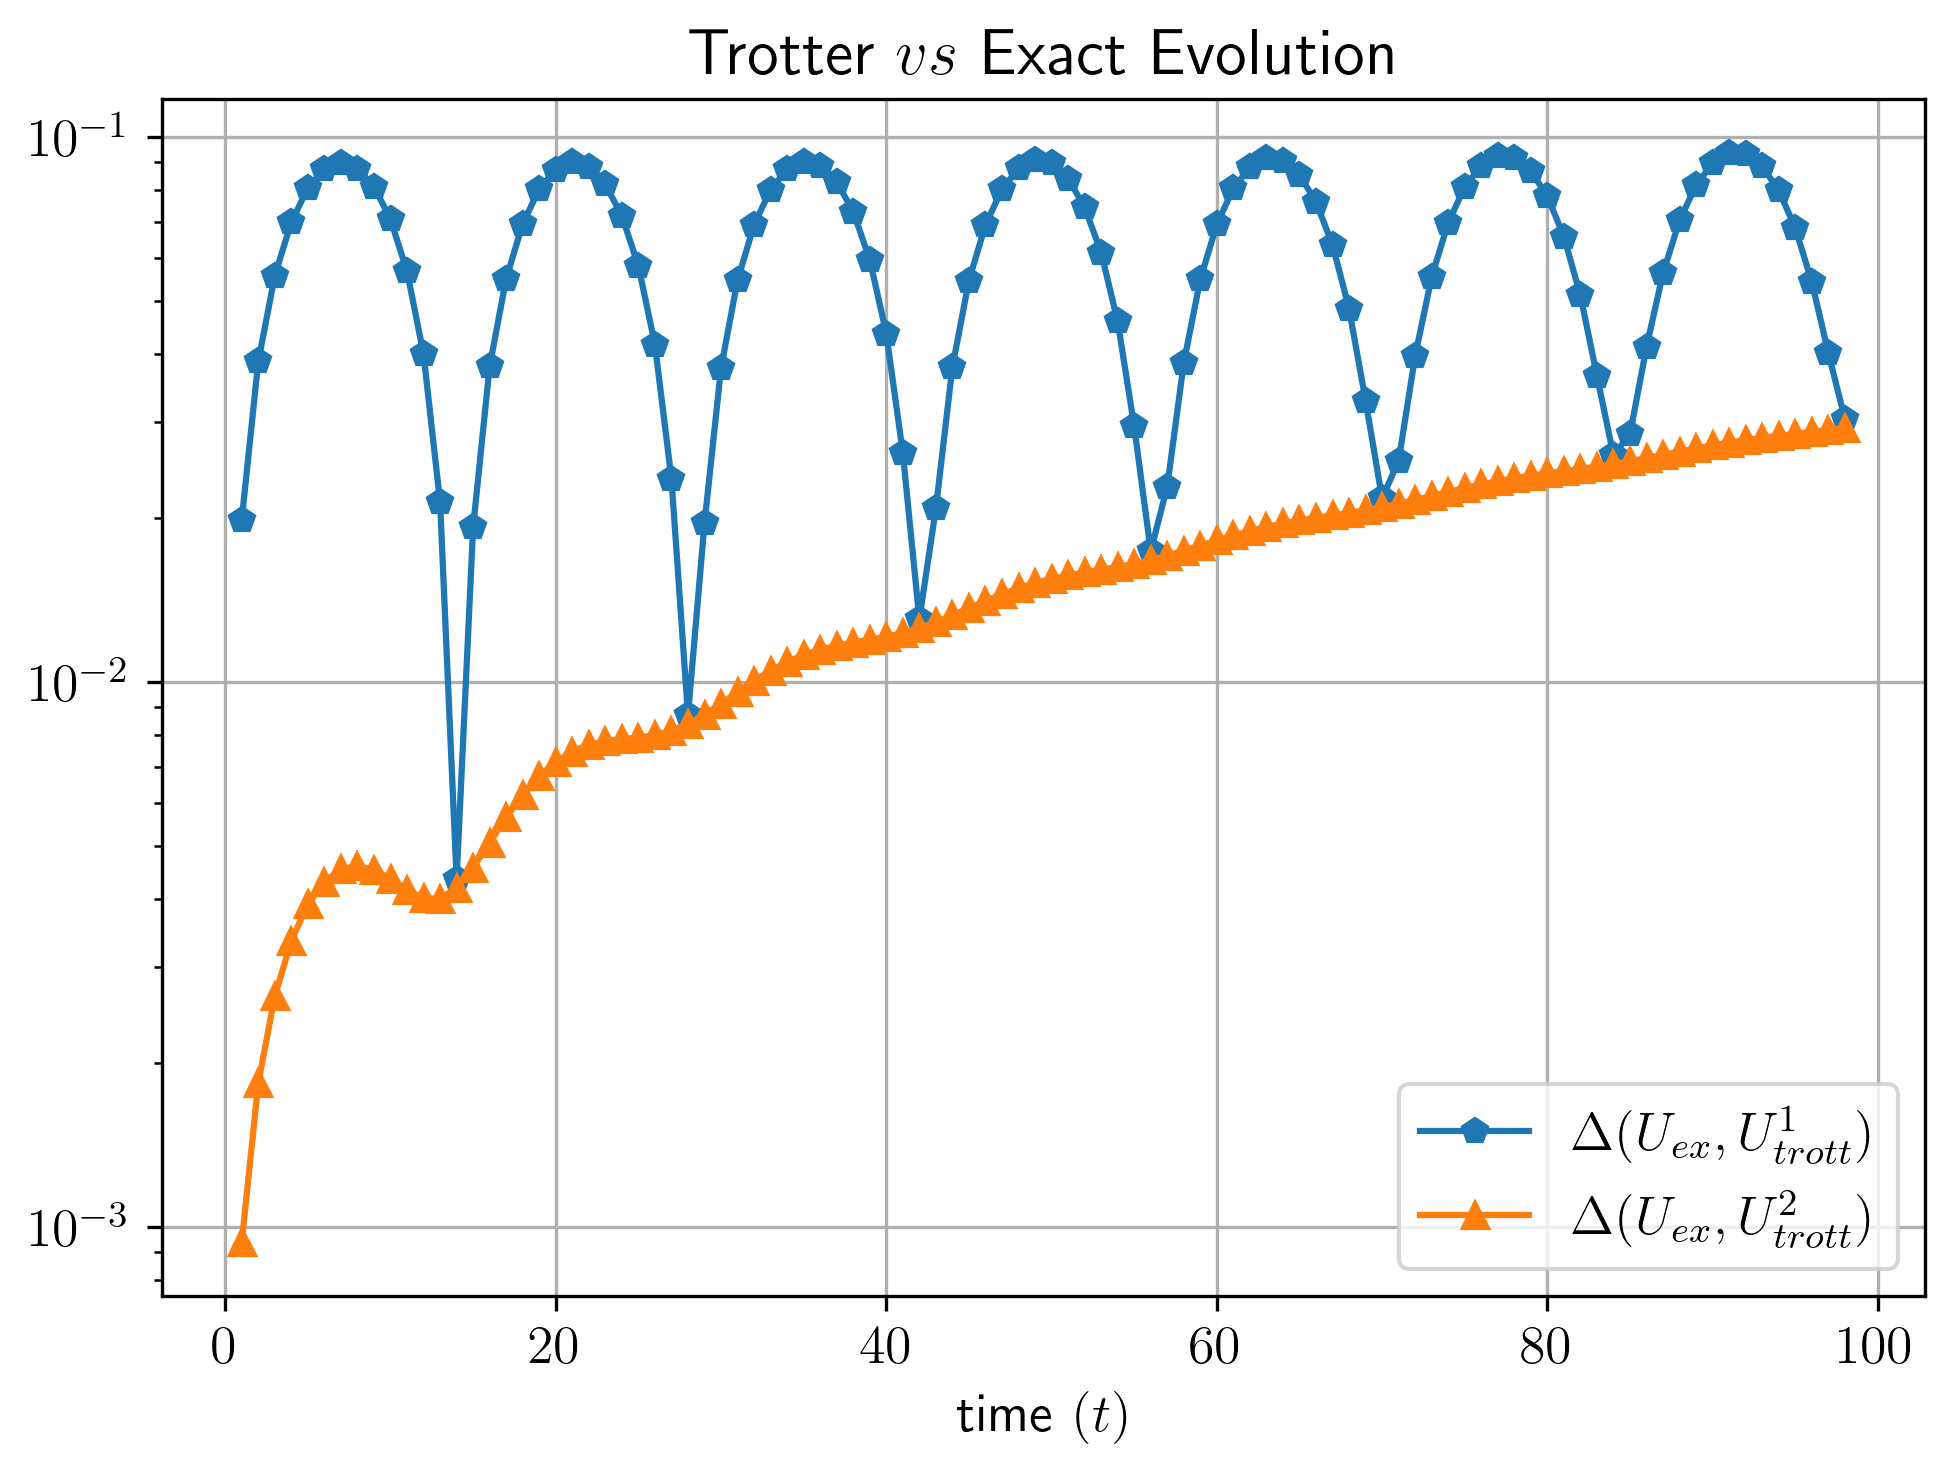

In [97]:
plt.plot(range(1,steps),diff1, marker="p", label="$\\Delta(U_{ex},U_{trott}^1)$")
plt.plot(range(1,steps),diff2, marker="^", label="$\\Delta (U_{ex},U_{trott}^2)$")
# plt.plot(range(1,steps),diff4, marker="+", label="$\\Delta (U_{ex},U_{trott}^4)$")
plt.title("Trotter $vs$ Exact Evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

## 2. Build evolution MPO for PBC

## 3. Compare MPO and Exact results